#Drive'a Bağlan

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Gerekli Kütüphanaleri Ekle

In [35]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed, BatchNormalization
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from python_speech_features import mfcc
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
from sklearn.model_selection import StratifiedKFold
import librosa

In [4]:
pip install python_speech_features

CSV Dosyasını Okuma

In [5]:
dataFrame = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Derin_Ogrenme/data.csv')
dataFrame.set_index('fname', inplace=True)

#Ses Verileri Görselleştirme Fonksiyonları

In [6]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(10,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for y in range(2):  # 1 satır var, bu yüzden sadece sütunlar arasında döngü yapıyoruz
        axes[y].set_title(list(signals.keys())[i])
        axes[y].plot(list(signals.values())[i])
        axes[y].get_xaxis().set_visible(False)
        axes[y].get_yaxis().set_visible(False)
        i += 1

In [7]:
def plot_fft(fft):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(10,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for y in range(2):
        data = list(fft.values())[i]
        Y, freq = data[0], data[1]
        axes [y].set_title(list(fft.keys()) [i])
        axes [y].plot(freq, Y)
        axes [y].get_xaxis().set_visible (False)
        axes [y].get_yaxis().set_visible (False)
        i += 1

In [9]:
def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(10,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        axes [x].set_title(list (fbank.keys()) [i])
        axes [x].imshow(list (fbank.values()) [i], cmap='hot', interpolation='nearest')
        axes[x].get_xaxis().set_visible (False)
        axes [x].get_yaxis().set_visible (False)
        i += 1

In [8]:
def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(10,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(1):
        for y in range(2):
            axes[y].set_title(list(mfccs.keys())[i])
            axes[y].imshow(list(mfccs.values())[i], cmap='hot', interpolation='nearest')
            axes[y].get_xaxis().set_visible(False)
            axes[y].get_yaxis().set_visible(False)
            i += 1

#SES İŞLEME

CSV Dosyarısını Oluşturma

In [10]:
dataFrame = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Derin_Ogrenme/data.csv")
dataFrame.set_index("fname", inplace=True) #inplace dataFrame i değiştiriyor. True yapmasaydık veri değişkene atamamız gerekecekti


.wav Dosyalarını Okuma ve Görselleştirme

In [11]:
for f in dataFrame.index:
    rate, signal = wavfile.read('/content/drive/MyDrive/Colab Notebooks/Derin_Ogrenme/cats_dogs/dataset/'+f) #rate=saniyedeki örnek sayısı ; signal=ses verisinin kendisi
    #signal.shape[0], sinyaldeki toplam örnek sayısını verir
    #"/rate"  ile ses dosyasının uzunluğu saniye cinsinden hesaplanır
    #hesaplanan uzunluk değeri, dataFrame'de ilgili dosyanın "length" sütununa atanır.
    dataFrame.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(dataFrame.label))  #Etiketleri classses listesine atıyor
class_dist = dataFrame.groupby(['label'])['length'].mean() #ortalamasına göre gruplandırıyor

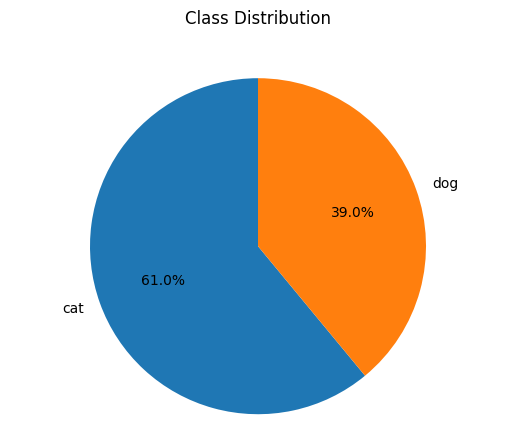

In [12]:
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%', shadow=False, startangle=90)
ax.axis('equal')
plt.show()
dataFrame.reset_index(inplace=True)

Fourier Transform Hesaplama

In [13]:
def calc_fft(y, rate):
    n = len(y)
    # fft.rfft ->  n-noktalı ayrık Fourier Dönüşümünü
    # DFT tamamen gerçek girdi için hesaplandığında, çıktı Hermit simetriktir, yani negatif frekans terimleri karşılık gelen pozitif frekans terimlerinin yalnızca karmaşık eşlenikleridir ve negatif frekans terimleri bu nedenle gereksizdir. Bu fonksiyon negatif frekans terimlerini hesaplamaz ve bu nedenle çıkışın dönüştürülmüş ekseninin uzunluğu n//2 + 1'dir.
    # rfft iki kat daha hızlıdır. Ayrıca spektrumun çizilmesi daha kolaydır
    freq = np.fft.rfftfreq(n, d=1/rate) # freq ile Ayrık Fourier Dönüşümü örnek frekanslarını döndürür
    Y = abs(np.fft.rfft(y)/n) #n e bölerek normalizasyon yaptık
    return (Y, freq)


Ses verilerini eğitime sokmak için düzenleme adımları
1.   Zaman domeni sinyalleri
2.   Fourier dönüşümleri
3.   Filterbank
4.   MFCC



In [14]:
signals = {}
fft = {}
fbank = {}
mfccs = {}

for c in classes:
    wav_file = dataFrame[dataFrame.label == c].iloc[0,0]
    signal, rate = librosa.load('/content/drive/MyDrive/Colab Notebooks/Derin_Ogrenme/cats_dogs/dataset/'+wav_file, sr=16000)
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)

    # mel filterbank
    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=400).T # T -> Transpoz
    fbank[c] = bank

    # MFCC
    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=36, nfft=400).T
    mfccs[c] = mel

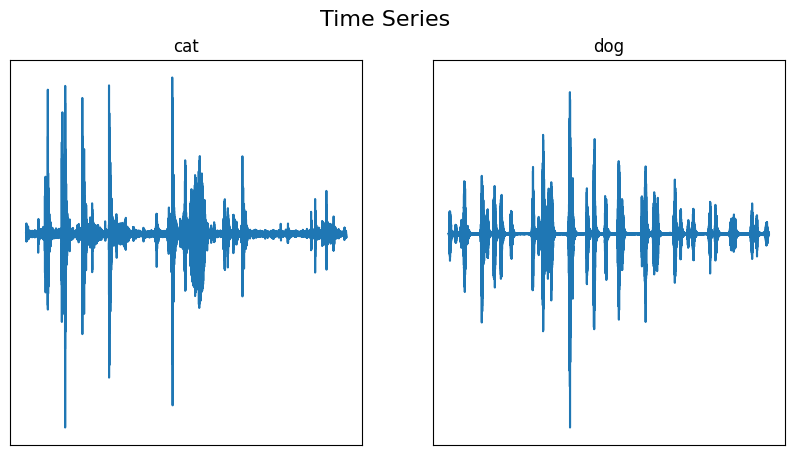

In [16]:
plot_signals(signals)
plt.show()

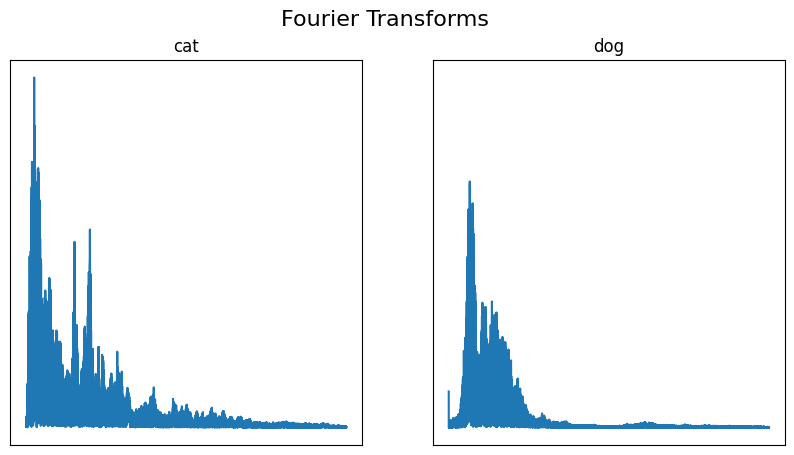

In [17]:
plot_fft(fft)
plt.show()

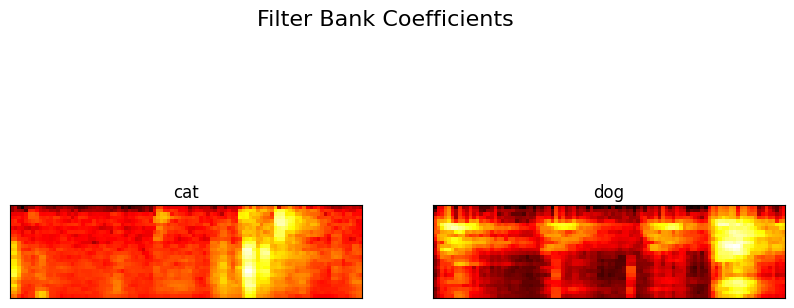

In [18]:
plot_fbank(fbank)
plt.show()

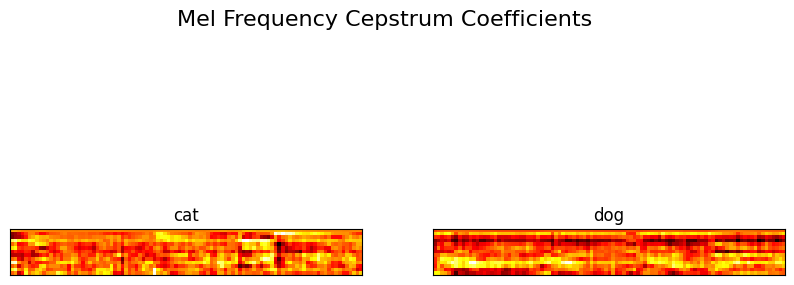

In [19]:
plot_mfccs(mfccs)
plt.show()

#Model

In [20]:
class Config:
    def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=512, rate=1600):
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        self.step = int(rate/10)


Ses dosyalarından rastgele örnekler alarak MFCC özelliklerini hesaplar ve veri kümesini oluşturur

In [26]:
def build_rand_feat():
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p=prob_dist)
        file = np.random.choice(dataFrame[dataFrame.label == rand_class].index)
        rate, wav = wavfile.read('/content/drive/MyDrive/Colab Notebooks/Derin_Ogrenme/cats_dogs/dataset/'+file)
        label = dataFrame.at[file, 'label']
        rand_index = np.random.randint(0, wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index+config.step]
        X_sample = mfcc(sample, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft).T
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        X.append(X_sample if config.mode == 'conv' else X_sample.T)
        y.append(classes.index(label))

    X, y = np.array(X), np.array(y)
    X  = (X - _min) / (_max - _min)
    if config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode == 'LTSM':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

    y = to_categorical(y, num_classes=2)

    return X, y

In [22]:
dataFrame = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Derin_Ogrenme/data.csv')
dataFrame.set_index('fname', inplace=True)

for f in dataFrame.index:
    rate, signal = wavfile.read('/content/drive/MyDrive/Colab Notebooks/Derin_Ogrenme/cats_dogs/dataset/'+ f)
    dataFrame.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(dataFrame.label))
class_dist = dataFrame.groupby(['label']) ['length'].mean()

n_samples = 2 * int(dataFrame['length'].sum()/0.1)
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

In [30]:
def get_conv_model2():
    # Seri model oluşturma
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
    model.add(MaxPool2D(1,2))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1), padding='same'))
    model.add(MaxPool2D(1,2))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), activation='relu', strides=(1,1), padding='same'))
    model.add(MaxPool2D(1,2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [ ]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1), padding='same'))
    model.add(Conv2D(64, (3,3), activation='relu', strides=(1,1), padding='same'))
    model.add(Conv2D(128, (3,3), activation='relu', strides=(1,1), padding='same'))
    model.add(MaxPool2D(1,2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [24]:
def get_recurrent_model():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout (0.5))
    model.add(TimeDistributed (Dense (64, activation='relu')))
    model.add(TimeDistributed (Dense (32, activation='relu')))
    model.add(TimeDistributed (Dense (16, activation='relu')))
    model.add(TimeDistributed (Dense (8, activation='relu')))
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [32]:
config = Config(mode='conv')

if config.mode == 'conv':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_conv_model2()
elif config.mode == 'LSTM':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model()

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# class_weight hesaplanması ve sözlüğe dönüştürülmesi
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_flat), y=y_flat)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Modelin eğitilmesi
history = model.fit(X_train, y_train, epochs=10, batch_size=32, shuffle=True, class_weight=class_weights_dict, validation_data=(X_test, y_test))


100%|██████████| 36976/36976 [02:44<00:00, 225.41it/s]


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 13, 1, 16)         160       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 1, 16)          0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 7, 1, 16)          64        
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 1, 32)          4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 4, 1, 32)          0         
 g2D)                                                            
                                                      

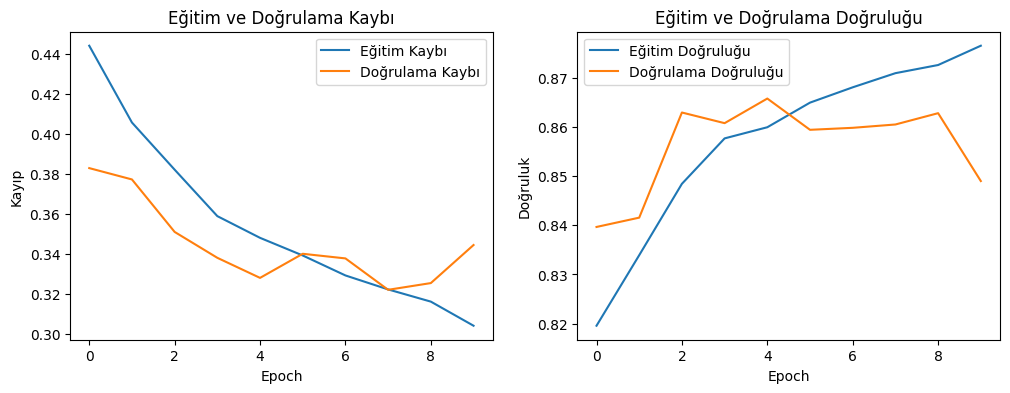

In [33]:
# Eğitim ve doğrulama kayıplarını ve doğruluklarını grafiğe dökme
plt.figure(figsize=(12, 4))

# Kayıp grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_acc'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.show()

In [29]:
config = Config(mode='LSTM')

if config.mode == 'conv':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_conv_model2()
elif config.mode == 'LSTM':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model()

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# class_weight hesaplanması ve sözlüğe dönüştürülmesi
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_flat), y=y_flat)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Modelin eğitilmesi
history = model.fit(X_train, y_train, epochs=10, batch_size=32, shuffle=True, class_weight=class_weights_dict, validation_data=(X_test, y_test))

100%|██████████| 36976/36976 [03:02<00:00, 202.78it/s]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            72704     
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            131584    
                                                                 
 dropout_2 (Dropout)         (None, 1, 128)            0         
                                                                 
 time_distributed (TimeDist  (None, 1, 64)             8256      
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 1, 32)             2080      
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 1, 16)            

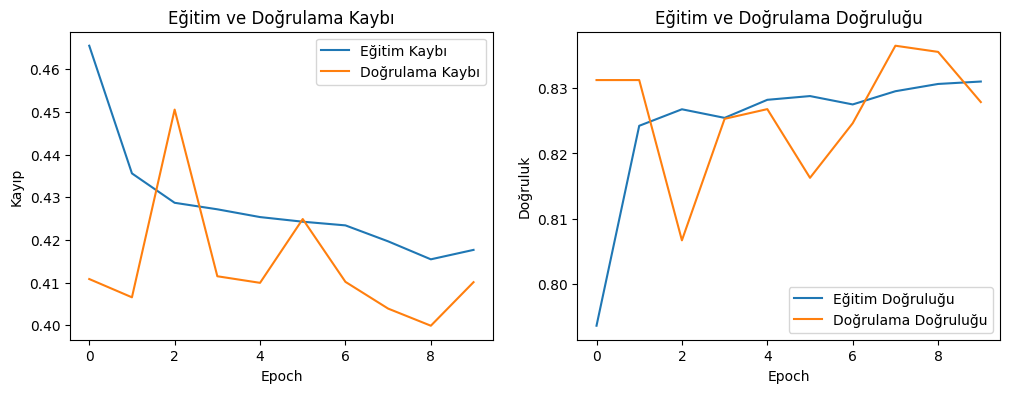

In [31]:
# Eğitim ve doğrulama kayıplarını ve doğruluklarını grafiğe dökme
plt.figure(figsize=(12, 4))

# Kayıp grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_acc'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.show()

In [37]:
config = Config(mode='conv')

X, y = build_rand_feat()
y_flat = np.argmax(y, axis=1)
input_shape = (X.shape[1], X.shape[2], 1) if config.mode == 'conv' else (X.shape[1], X.shape[2])

# StratifiedKFold kullanarak K=5 için çapraz doğrulama
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvscores = []
for train, test in kfold.split(X, y_flat):
    if config.mode == 'conv':
        model = get_conv_model2()
    elif config.mode == 'time':
        model = get_recurrent_model()

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_flat[train]), y=y_flat[train])
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

    history = model.fit(X[train], y[train], epochs=10, batch_size=32, shuffle=True, class_weight=class_weights_dict, validation_data=(X[test], y[test]))

    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'%s: %.2f%%' % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print('%.2f%% (+/- %.2f%%)' % (np.mean(cvscores), np.std(cvscores)))

100%|██████████| 36976/36976 [02:57<00:00, 208.31it/s]


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 13, 1, 16)         160       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 7, 1, 16)          0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Bat  (None, 7, 1, 16)          64        
 chNormalization)                                                
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 1, 32)          4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 4, 1, 32)          0         
 g2D)                                                            
                                                      

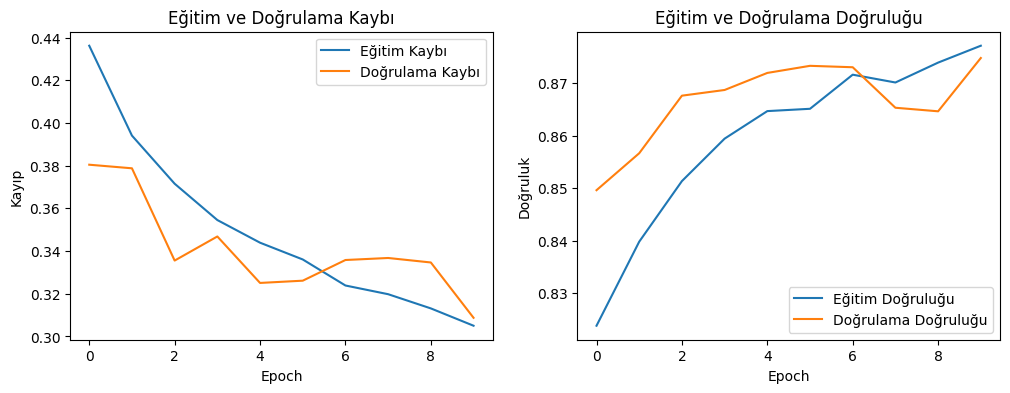

In [38]:
# Eğitim ve doğrulama kayıplarını ve doğruluklarını grafiğe dökme
plt.figure(figsize=(12, 4))

# Kayıp grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_acc'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.show()

In [45]:
config = Config(mode='LTSM')

X, y = build_rand_feat()
y_flat = np.argmax(y, axis=1)
input_shape = (X.shape[1], X.shape[2], 1) if config.mode == 'conv' else (X.shape[1], X.shape[2])

# StratifiedKFold kullanarak K=5 için çapraz doğrulama
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvscores = []
for train, test in kfold.split(X, y_flat):
    if config.mode == 'conv':
        model = get_conv_model2()
    elif config.mode == 'LTSM':
        model = get_recurrent_model()

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_flat[train]), y=y_flat[train])
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

    history = model.fit(X[train], y[train], epochs=10, batch_size=32, shuffle=True, class_weight=class_weights_dict, validation_data=(X[test], y[test]))

    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'%s: %.2f%%' % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print('%.2f%% (+/- %.2f%%)' % (np.mean(cvscores), np.std(cvscores)))

100%|██████████| 36976/36976 [02:46<00:00, 221.93it/s]


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 128)            72704     
                                                                 
 lstm_3 (LSTM)               (None, 1, 128)            131584    
                                                                 
 dropout_15 (Dropout)        (None, 1, 128)            0         
                                                                 
 time_distributed_4 (TimeDi  (None, 1, 64)             8256      
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 1, 32)             2080      
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, 1, 16)           

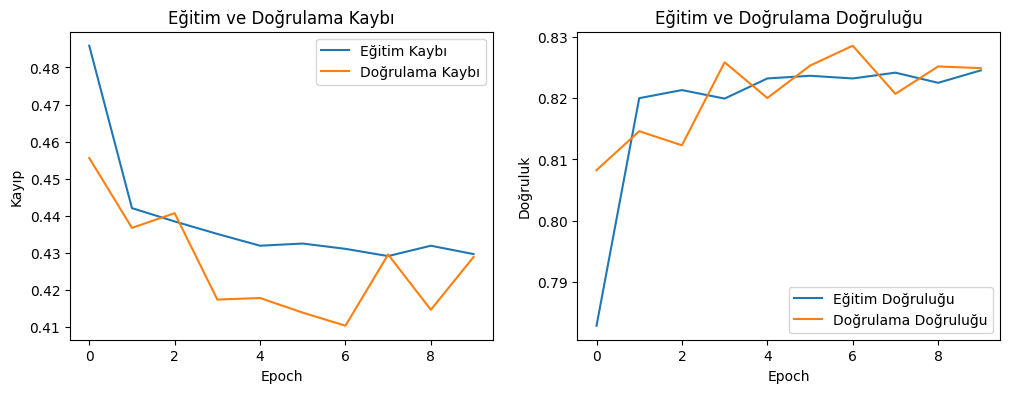

In [46]:
# Eğitim ve doğrulama kayıplarını ve doğruluklarını grafiğe dökme
plt.figure(figsize=(12, 4))

# Kayıp grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_acc'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.show()

In [41]:
def get_conv_model3():
    model = Sequential()
    # İlk Conv2D Katmanı
    model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(MaxPool2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    # İkinci Conv2D Katmanı
    model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same'))
    model.add(MaxPool2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    # Üçüncü Conv2D Katmanı
    model.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same'))
    model.add(MaxPool2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    # Flatten ve Dense Katmanları
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model


In [42]:
config = Config(mode='conv')

X, y = build_rand_feat()
y_flat = np.argmax(y, axis=1)
input_shape = (X.shape[1], X.shape[2], 1) if config.mode == 'conv' else (X.shape[1], X.shape[2])

# StratifiedKFold kullanarak K=5 için çapraz doğrulama
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvscores = []
for train, test in kfold.split(X, y_flat):
    if config.mode == 'conv':
        model = get_conv_model2()
    elif config.mode == 'time':
        model = get_recurrent_model()

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_flat[train]), y=y_flat[train])
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

    history = model.fit(X[train], y[train], epochs=10, batch_size=32, shuffle=True, class_weight=class_weights_dict, validation_data=(X[test], y[test]))

    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'%s: %.2f%%' % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print('%.2f%% (+/- %.2f%%)' % (np.mean(cvscores), np.std(cvscores)))

100%|██████████| 36976/36976 [02:48<00:00, 218.98it/s]


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 13, 1, 32)         320       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 7, 1, 32)          0         
 ng2D)                                                           
                                                                 
 batch_normalization_24 (Ba  (None, 7, 1, 32)          128       
 tchNormalization)                                               
                                                                 
 conv2d_26 (Conv2D)          (None, 7, 1, 32)          9248      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 4, 1, 32)          0         
 ng2D)                                                           
                                                      

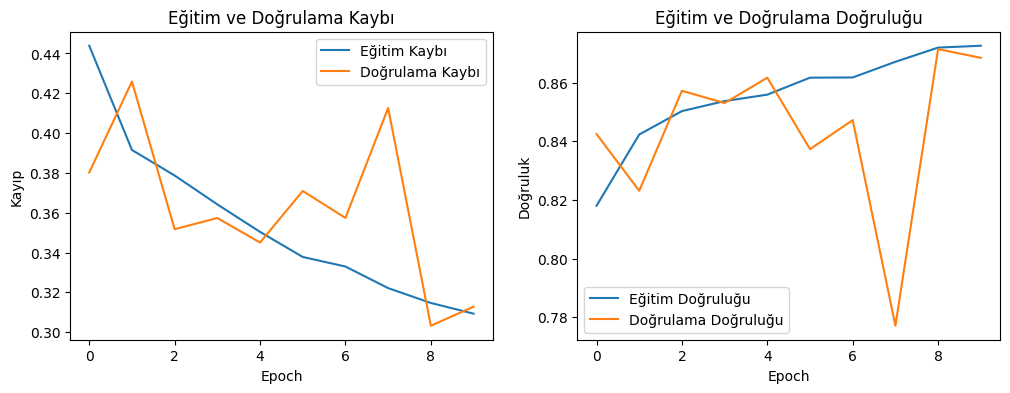

In [43]:
# Eğitim ve doğrulama kayıplarını ve doğruluklarını grafiğe dökme
plt.figure(figsize=(12, 4))

# Kayıp grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_acc'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.show()